In [2]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch-2.git
import sys, os
sys.path.append('/content/deep-learning-from-scratch-2')

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 606 (delta 1), reused 5 (delta 0), pack-reused 598
Receiving objects: 100% (606/606), 29.82 MiB | 36.22 MiB/s, done.
Resolving deltas: 100% (361/361), done.


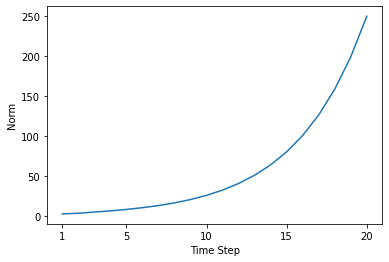

In [5]:
# Gradient Graph 구현

import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
  dh = np.matmul(dh, Wh.T)
  norm = np.sqrt(np.sum(dh**2)) / N
  norm_list.append(norm)


plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('Time Step')
plt.ylabel('Norm')
plt.show()

In [6]:
# Clip Grads 구현

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
  total_norm = 0
  for grad in grads:
    total_norm += np.sum(grad**2)
  total_norm = np.sqrt(total_norm)

  rate = max_norm / (total_norm + 1e-6) # threshold를 초과했을 때 기울기 수정하며 1e-6처럼 작은 수를 더해서 0이 되는 경우 차단
  if rate < 1:
    for grad in grads:
      grad *= rate

In [7]:
# LSTM 구현
from common.functions import sigmoid
class LSTM:
  def __init__(self, Wx, Wh, b): # 초기화
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev, c_prev):
      Wx, Wh, b = self.params
      N, H = h_prev.shape

      A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

      # slice
      f = A[:, :H] # forget gate
      g = A[:, H:2*H] # tanh 노드
      i = A[:, 2*H:3*H] # input gate
      o = A[:, 3*H:] # output gate

      f = sigmoid(f)
      g = np.tanh(g)
      i = sigmoid(i)
      o = sigmoid(o)

      c_next = f * c_prev + g * i # 다음 셀 식
      h_next = o * np.tanh(c_next) # 아웃게이트와 c_next 원소별 곱 

      self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
      return h_next, c_next

  def backward(self, dh_next, dc_next):
      Wx, Wh, b = self.params
      x, h_prev, c_prev, i, f, g, o, c_next = self.cache

      tanh_c_next = np.tanh(c_next)

      ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

      dc_prev = ds * f

      di = ds * g # input gate gradient
      df = ds * c_prev # forget gate gradient
      do = dh_next * tanh_c_next # output gate gradient
      dg = ds * i # tanh노드 gradient

      di *= i * (1 - i)
      df *= f * (1 - f)
      do *= o * (1 - o)
      dg *= (1 - g ** 2)

      # slice노드의 역전파 4개의 행렬 연결
      dA = np.hstack((df, dg, di, do))

      dWh = np.dot(h_prev.T, dA)
      dWx = np.dot(x.T, dA)
      db = dA.sum(axis=0)

      self.grads[0][...] = dWx
      self.grads[1][...] = dWh
      self.grads[2][...] = db

      dx = np.dot(dA, Wx.T)
      dh_prev = np.dot(dA, Wh.T)

      return dx, dh_prev, dc_prev

In [8]:
# TimeLSTM 구현
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful=False): # lstm 초기화
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None
    self.h, self.c = None, None
    self.dh = None
    self.stateful = stateful # 상태를 유지할지 지정하는 변수지정

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]

    self.layers = []
    hs = np.empty((N,T, H), dtype='f')

    if not self.stateful or self.h is None: # stateful이 없거나 h가 None일때 0으로 지정
      self.h = np.zeros((N,H), dtype='f')
    if not self.stateful or self.c is None: # stateful이 없거나 c가 None일때 0으로 지정
      self.c = np.zeros((N,H), dtype='f')

    for t in range(T): # 시계열 데이터를 한번에 처리하는 계층
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h
      self.layers.append(layer)
    return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]

    dxs = np.empty((N, T, D), dtype='f')
    dh, dc = 0, 0

    grads = [0, 0, 0]
    for t in reversed(range(T)): # 역전파의 연결은 적당한 길이로 끊고 순전파의 흐름은 유지
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
      dxs[:, t, :] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad

    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
      self.dh = dh
      return dxs

  def set_state(self, h, c=None):
    self.h, self.c = h, c

  def reset_state(self):
    self.h, self.c = None, None

In [9]:
# Rnnlm 구현
from common.time_layers import *
import pickle

class Rnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
    V,D,H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    # 가중치 초기화
    embed_W = (rn(V,D) / 100).astype('f')
    lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    # 계층생성 Embedding - LSTM - Affine의 간단한 계층
    self.layers = [
                   TimeEmbedding(embed_W),
                   TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
                   TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]

    # 모든 가중치와 기울기를 리스트에 모음
    self.params, self.grads = [],[]
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def predict(self, xs):
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs

  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.lstm_layer.reset_state()

  def save_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'wb') as f:
      pickle.dump(self.params, f)

  def load_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'rb') as f:
      self.params = pickle.load(f)

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.62
| 에폭 1 |  반복 131 / 1327 | 시간 42[s] | 퍼플렉서티 985.58
| 에폭 1 |  반복 261 / 1327 | 시간 85[s] | 퍼플렉서티 515.18
| 에폭 1 |  반복 391 / 1327 | 시간 127[s] | 퍼플렉서티 381.13
| 에폭 1 |  반복 521 / 1327 | 시간 169[s] | 퍼플렉서티 318.35
| 에폭 1 |  반복 651 / 1327 | 시간 212[s] | 퍼플렉서티 290.76
| 에폭 1 |  반복 781 / 1327 | 시간 254[s] | 퍼플렉서티 234.57
| 에폭 1 |  반복 911 / 1327 | 시간 296[s] | 퍼플렉서티 225.95
| 에폭 1 |  반복 1041 / 1327 | 시간 338[s] | 퍼플렉서티 220.30
| 에폭 1 |  반복 1171 / 1327 | 시간 380[s] | 퍼플렉서티 193.71
| 에폭 1 |  반복 1301 / 1327 | 시간 422[s] | 퍼플렉서티 180.08
| 에폭 2 |  반복 1 / 1327 | 시간 430[s] | 퍼플렉서티 211.82
| 에폭 2 |  반복 131 / 1327 | 시간 472[s] | 퍼플렉서티 170.60
| 에폭 2 |  반복 261 / 1327 | 시간 513[s] | 퍼플렉서티 185.95
| 에폭 2 |  반복 391 / 1327 | 시간 556[s] | 퍼플렉서티 165.77
| 에폭 2 |  반복 521 / 1327 | 시간 598[s] | 퍼플렉서티 161.54
| 에폭 2 |  반복 651 / 1327 | 시간 640[s] | 퍼플렉서티 163.30
| 에폭 2 |  반복 781 / 1327 | 시간 682[s] | 퍼플렉서티 139.71
| 에폭 2 |  반복 911 / 1327 | 시간 724[s] | 퍼플렉서티 143.79
| 에폭 2 |  반복 1041 / 1327 | 시간 765[s

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_

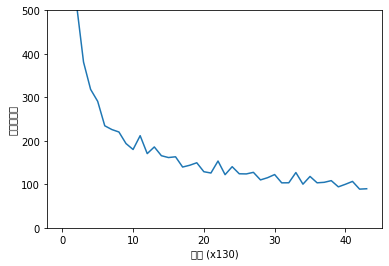

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  135.3639414294125


In [12]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
# Train

# Hyperparameter
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# Data Read
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# Model
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# Cliping
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=130)
trainer.plot(ylim=(0, 500))

# Test eval
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# save
model.save_params()

In [13]:
# BetterRnnlm 구현
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel
import pickle

class BetterRnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
    V,D,H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    # 가중치 초기화
    embed_W = (rn(V,D) / 100).astype('f')
    lstm_Wx1 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
    lstm_Wh1 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b1 = np.zeros(4*H).astype('f')
    lstm_Wx2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_Wh2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b2 = np.zeros(4*H).astype('f')
    affine_b = np.zeros(V).astype('f')

    # 계층생성 Embedding - Dropout - LSTM - Dropout - LSTM - Affine LSTM 위 아래로 드롭아웃
    self.layers = [
                   TimeEmbedding(embed_W),
                   TimeDropout(dropout_ratio), # 드롭아웃 상하로 설정
                   TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
                   TimeDropout(dropout_ratio),
                   TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
                   TimeDropout(dropout_ratio),
                   TimeAffine(affine_W.T, affine_b) # 가중치 공유
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layers = [self.layers[2], self.layers[4]]
    self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

    # 모든 가중치와 기울기를 리스트에 모음
    self.params, self.grads = [],[]
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def predict(self, xs, train_fig=False):
    for layer in self.drop_layers:
      layer.train_fig = train_fig
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs

  def forward(self, xs, ts, train_fig=True):
    score = self.predict(xs, train_fig)
    loss = self.loss_layer.forward(score, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    for layer in self.lstm_layers:
      self.lstm_layer.reset_state()

In [ ]:
from common import config
# config.GPU = True
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm

# Better Train

# Hyperparameter
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# Data Read
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# Model
model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# Test eval
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)
